Trial 5 Complete [00h 08m 55s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 11m 08s


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training the CNN...
Training on data with shape: (6800, 224, 224, 3)
Epoch 1/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 284s 475ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 275s 462ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 274s 460ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 275s 462ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 270s 454ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
595/595 ━━━━━━━━━━━━━━━━━━━━ 283s 475ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


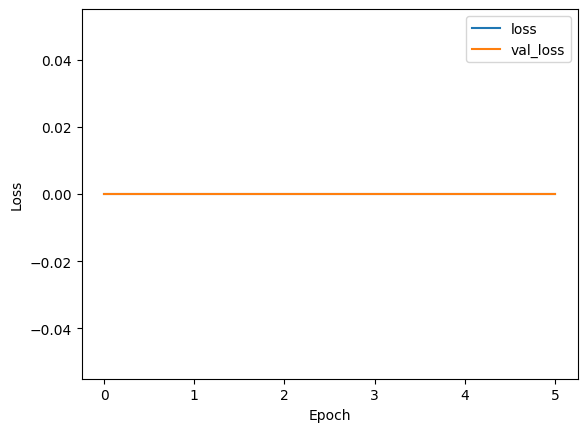

Testing the CNN...
Testing on data with shape: (9200, 224, 224, 3)
288/288 ━━━━━━━━━━━━━━━━━━━━ 103s 332ms/step
Predicted classes: [0 0 0 ... 0 0 0]


In [4]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt

# Function to load the UCSD Pedestrian dataset
def load_ucsd_pedestrian_dataset(train_path, test_path, image_size):
    train_images = []  # Normal frames (Train set, label = 0)
    train_labels = []

    test_images = []  # Test frames (no labels, unsupervised anomaly detection)

    # Load normal frames from Train folder (all labeled as 0)
    for dirpath, _, filenames in os.walk(train_path):
        for file in filenames:
            if file.endswith(('.jpg', '.png', '.tif')):
                image_path = os.path.join(dirpath, file)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)  # Resizing to hyperparameter-controlled size
                    image = image.astype('float32') / 255.0
                    train_images.append(image)
                    train_labels.append(0)  # Normal frames = 0
    
    # Load Test frames (no labels provided)
    for dirpath, _, filenames in os.walk(test_path):
        for file in filenames:
            if file.endswith(('.jpg', '.png', '.tif', '.bmp')):
                image_path = os.path.join(dirpath, file)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    image = image.astype('float32') / 255.0
                    test_images.append(image)
    
    # Convert to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)

    print(f"Loaded {len(train_images)} training images and {len(test_images)} testing images.")
    return train_images, train_labels, test_images

# CNN Model with Fixed Output Size After Flattening
def create_cnn_model(hp):
    model = Sequential()
    
    # Tunable number of filters for each Conv2D layer
    model.add(Conv2D(filters=hp.Int('filters_1', 32, 128, step=32), kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(filters=hp.Int('filters_2', 64, 256, step=64), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(filters=hp.Int('filters_3', 128, 512, step=128), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output to match the input size of the dense layer
    model.add(Flatten())
    
    # Calculate the output size after Flattening (using a fixed image size)
    model.add(Dense(units=hp.Int('dense_units_1', 128, 512, step=128), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units_2', 64, 256, step=64), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification
    
    # Compile the model with a tunable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Hyperparameter tuning using Keras Tuner
def tune_hyperparameters(train_images, train_labels):
    tuner = RandomSearch(
        create_cnn_model,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=1,
        directory='cnn_tuning',
        project_name='ucsd_pedestrian_tuning'
    )

    # Run the search
    tuner.search(train_images, train_labels, epochs=5, validation_split=0.2)
    
    # Get the best model after tuning
    best_model = tuner.get_best_models(num_models=1)[0]
    
    return best_model

# Train the CNN model
def train_cnn(model, train_images, train_labels, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    print(f"Training on data with shape: {train_images.shape}")
    
    history = model.fit(train_images, train_labels,  # Train on images and their corresponding labels
                        validation_split=0.3,  # Using 30% of training data for validation
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    return history

# Test the model on the test dataset (no labels)
def test_cnn(model, test_images):
    print(f"Testing on data with shape: {test_images.shape}")
    
    # Predict classes
    predictions = model.predict(test_images)
    predicted_classes = (predictions > 0.5).astype("int32")  # Thresholding for binary classification
    
    print(f"Predicted classes: {predicted_classes.flatten()}")
    
    return predicted_classes

# Main function to execute the workflow for UCSD dataset
def main():
    train_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Train'  # Path to the Train folder
    test_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Test'  # Path to the Test folder
    
    # Load the dataset without labels for test data
    image_size = (224, 224)  # Default image size (fixed for now to avoid shape mismatches)
    train_images, train_labels, test_images = load_ucsd_pedestrian_dataset(train_path, test_path, image_size)

    # Hyperparameter tuning
    best_model = tune_hyperparameters(train_images, train_labels)
    
    # Train the CNN
    batch_size = 8
    epochs = 15
    print("Training the CNN...")
    history = train_cnn(best_model, train_images, train_labels, batch_size, epochs)
    
    # Plot training history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Test the CNN and get predictions
    print("Testing the CNN...")
    predicted_classes = test_cnn(best_model, test_images)

if __name__ == "__main__":
    main()


In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

# Function to load the UCSD Pedestrian dataset
def load_ucsd_pedestrian_dataset(train_path, test_path, image_size):
    train_images = []  # Normal frames (Train set, label = 0)
    train_labels = []

    test_images = []  # Test frames (no labels, unsupervised anomaly detection)
    test_labels = []  # Optional: Add ground truth labels here if available

    # Load normal frames from Train folder (all labeled as 0)
    for dirpath, _, filenames in os.walk(train_path):
        for file in filenames:
            if file.endswith(('.jpg', '.png', '.tif', '.bmp')):
                image_path = os.path.join(dirpath, file)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)  # Resizing to hyperparameter-controlled size
                    image = image.astype('float32') / 255.0
                    train_images.append(image)
                    train_labels.append(0)  # Normal frames = 0
    
    # Load Test frames (assuming no labels for now, but if you have labels, update accordingly)
    for dirpath, _, filenames in os.walk(test_path):
        for file in filenames:
            if file.endswith(('.jpg', '.png', '.tif', '.bmp')):
                image_path = os.path.join(dirpath, file)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    image = image.astype('float32') / 255.0
                    test_images.append(image)
                    test_labels.append(1)  # If you have test labels, assign accordingly
    
    # Convert to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    print(f"Loaded {len(train_images)} training images and {len(test_images)} testing images.")
    return train_images, train_labels, test_images, test_labels

# CNN Model with Fixed Output Size After Flattening
def create_cnn_model(hp):
    model = Sequential()
    
    # Tunable number of filters for each Conv2D layer
    model.add(Conv2D(filters=hp.Int('filters_1', 32, 128, step=32), kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(filters=hp.Int('filters_2', 64, 256, step=64), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(filters=hp.Int('filters_3', 128, 512, step=128), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output to match the input size of the dense layer
    model.add(Flatten())
    
    # Calculate the output size after Flattening (using a fixed image size)
    model.add(Dense(units=hp.Int('dense_units_1', 128, 512, step=128), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units_2', 64, 256, step=64), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification
    
    # Compile the model with a tunable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Hyperparameter tuning using Keras Tuner
def tune_hyperparameters(train_images, train_labels):
    tuner = RandomSearch(
        create_cnn_model,
        objective='val_accuracy',
        max_trials=2,
        executions_per_trial=1,
        directory='cnn_tuning',
        project_name='ucsd_pedestrian_tuning'
    )

    # Run the search
    tuner.search(train_images, train_labels, epochs=5, validation_split=0.2)
    
    # Get the best model after tuning
    best_model = tuner.get_best_models(num_models=1)[0]
    
    return best_model

# Train the CNN model
def train_cnn(model, train_images, train_labels, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    print(f"Training on data with shape: {train_images.shape}")
    
    history = model.fit(train_images, train_labels,  # Train on images and their corresponding labels
                        validation_split=0.3,  # Using 30% of training data for validation
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    return history

# Test the model on the test dataset and calculate accuracy + AUC
def test_cnn_with_metrics(model, test_images, test_labels):
    print(f"Testing on data with shape: {test_images.shape}")
    
    # Predict probabilities (for AUC)
    predictions = model.predict(test_images).flatten()
    
    # Predicted classes (for accuracy)
    predicted_classes = (predictions > 0.5).astype("int32")
    
    print(f"Predicted classes: {predicted_classes}")
    
    # Calculate accuracy if test labels are available
    if test_labels is not None:
        accuracy = accuracy_score(test_labels, predicted_classes)
        auc = roc_auc_score(test_labels, predictions)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Test AUC: {auc:.2f}")
        return accuracy, auc
    else:
        print("No test labels provided, unable to calculate accuracy or AUC.")
        return None, None

# Main function to execute the workflow for UCSD dataset
def main():
    train_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Train'  # Path to the Train folder
    test_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Test'  # Path to the Test folder
    
    # Load the dataset without labels for test data
    image_size = (224, 224)  # Default image size (fixed for now to avoid shape mismatches)
    train_images, train_labels, test_images, test_labels = load_ucsd_pedestrian_dataset(train_path, test_path, image_size)

    # Hyperparameter tuning
    best_model = tune_hyperparameters(train_images, train_labels)
    
    # Train the CNN
    batch_size = 8
    epochs = 10
    print("Training the CNN...")
    history = train_cnn(best_model, train_images, train_labels, batch_size, epochs)
    
    # Plot training history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Test the CNN and get predictions + accuracy + AUC (if test labels are available)
    print("Testing the CNN...")
    test_accuracy, test_auc = test_cnn_with_metrics(best_model, test_images, test_labels)

if __name__ == "__main__":
    main()


KeyboardInterrupt: 